In [1]:
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams['font.family'] = 'Malgun Gothic'
import datetime

In [2]:
date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')

In [3]:
date_today_record = str(date_today).split(' ')[0].replace('-', '')
date_today_record

'20210614'

In [4]:
def day_modifier(x):
    # x is a number
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x)
        if len(x) == 1:
            return '0' + x
        else:
            return x

In [5]:
def landnum_modifier(x):
    # x is a string
    
    if pd.isna(x) == True:
        return x
    else:
        x = str(x).replace('외', '').replace(' ','')
        splitted = x.split('-')
        if len(splitted) == 1:
            return x + '-0'
        else:
            return x

In [6]:
def data_prep(bdtype, tradetype):
    # bdtype is a string: one of 아파트, 연립다세대 or 오피스텔
    # tradetype is a string: one of 매매 or 전월세
    
    basedir = './국토교통부_실거래가_공개시스템/{}/{}/'.format(bdtype, tradetype)
    filenames = [f for f in os.listdir(basedir) if (f.endswith('.csv'))&('(' in f)]
    
    dfs_list = []
    for i, f in tqdm(enumerate(filenames)):
        df = pd.read_csv(basedir + f, encoding='euc-kr', header=15)
        if '해제사유발생일' in df.columns.tolist():
            df = df[df['해제사유발생일'].isna()]
            df = df.drop(columns=['해제사유발생일'])

        dfs_list.append(df)
    
    concat_df = pd.concat(dfs_list).reset_index(drop=True)
        
    concat_df['번지'] = concat_df['번지'].apply(landnum_modifier)
    
    concat_df['계약년월'] = concat_df['계약년월'].apply(str)
    concat_df['계약일'] = concat_df['계약일'].apply(str)
    
    concat_df['계약날짜기준_건물연식'] = concat_df['계약년월'].apply(lambda x: int(x[:4])) - concat_df['건축년도']
    
    concat_df['계약일'] = concat_df['계약일'].apply(day_modifier)
    
    concat_df['계약날짜'] = concat_df['계약년월'].apply(lambda x: x[:4]) + '-' + concat_df['계약년월'].apply(lambda x: x[-2:])\
    + '-' + concat_df['계약일']
    
    concat_df['계약날짜'] = pd.to_datetime(concat_df['계약날짜'], format='%Y-%m-%d')
    
    concat_df['거래금액(만원)'] = concat_df['거래금액(만원)'].apply(lambda x: int(x.replace(',','')))
    concat_df['단가(만원/㎡)'] = concat_df['거래금액(만원)'] / concat_df['전용면적(㎡)']
    
    concat_df['지번주소'] = concat_df['시군구'] + ' ' + concat_df['번지']
        
    cols_to_drop = ['시군구', '번지', '본번', '부번', '지번주소', '계약년월', '계약일', '도로명']
        
    concat_df = concat_df[['지번주소', '도로명'] + [col for col in concat_df.columns if col not in cols_to_drop]]
    
    date_today = pd.to_datetime(datetime.datetime.now().strftime('%Y-%m-%d'), format='%Y-%m-%d')
    concat_df['건물연식'] = date_today.year - concat_df['건축년도']
    
    concat_df = concat_df.dropna(subset=['지번주소'])
    
    if '건물명' in concat_df.columns:
        concat_df.rename(columns={'건물명':'건물(단지)명'}, inplace=True)
    elif '단지명' in concat_df.columns:
        concat_df.rename(columns={'단지명':'건물(단지)명'}, inplace=True)
    
    concat_df = concat_df[concat_df['층'] >= 0].reset_index(drop=True)
    
    return concat_df

In [7]:
target_house = '연립다세대'
house_df = data_prep(target_house, '매매')
house_df['부동산유형'] = target_house
print(house_df.shape)
house_df.head()

16it [00:01, 10.50it/s]


(637843, 13)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형
0,서울특별시 강남구 개포동 171-13,선릉로14길 11,(171-13),68.08,56.10,56500,2,1988.0,18.0,2006-12-20,829.905993,33.0,연립다세대
1,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,40500,2,1988.0,18.0,2006-12-09,770.108386,33.0,연립다세대
2,서울특별시 강남구 개포동 1239-7,개포로15길 25,강남빌라 가동,52.59,45.00,42000,1,1988.0,18.0,2006-12-19,798.630918,33.0,연립다세대
3,서울특별시 강남구 개포동 1239-6,개포로15길 27,강남빌라 나동,52.75,44.68,22000,2,1988.0,18.0,2006-11-02,417.061611,33.0,연립다세대
4,서울특별시 강남구 개포동 1175-2,논현로6길 36-8,강남파크,49.43,23.70,17000,4,1993.0,13.0,2006-07-19,343.920696,28.0,연립다세대


In [8]:
land_specs_df = pd.read_csv('./prepped_data/land_specs_ver_4.csv')
print(land_specs_df.shape)
land_specs_df.head()

(8706295, 11)


,지번주소,년,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,공시지가
0,서울특별시 강남구 개포동 100-0,2013,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,325000.0
1,서울특별시 강남구 개포동 100-0,2014,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,330000.0
2,서울특별시 강남구 개포동 100-0,2015,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,335000.0
3,서울특별시 강남구 개포동 100-0,2016,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,345000.0
4,서울특별시 강남구 개포동 100-0,2017,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지,355000.0


In [9]:
last_df = land_specs_df.drop_duplicates(subset=['지번주소'], keep='last').drop(columns=['년', '공시지가']).reset_index(drop=True)
print(last_df.shape)
last_df.head()

(981464, 9)


,지번주소,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면
0,서울특별시 강남구 개포동 100-0,전,876.0,자연녹지지역,지정되지않음,전,완경사,부정형,맹지
1,서울특별시 강남구 개포동 101-0,전,641.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
2,서울특별시 강남구 개포동 102-0,전,509.0,자연녹지지역,지정되지않음,전,평지,부정형,맹지
3,서울특별시 강남구 개포동 103-0,전,48.7,자연녹지지역,개발제한구역,전,평지,부정형,맹지
4,서울특별시 강남구 개포동 104-1,전,2995.0,개발제한구역,자연녹지지역,전,완경사,부정형,맹지


In [10]:
house_merge_df = house_df.merge(last_df, on=['지번주소']).reset_index(drop=True)
print(house_merge_df.shape)

(635273, 21)


In [11]:
house_df['구'] = house_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_df['동'] = house_df['지번주소'].apply(lambda x: x.split(' ')[2])
house_merge_df['구'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[1])
house_merge_df['동'] = house_merge_df['지번주소'].apply(lambda x: x.split(' ')[2])

In [12]:
target_gu = '강동구'
target_dong = '암사동'
#target_purpose = '준주거'
target_building_age = 5
target_period = 36 # in months

In [13]:
target_df = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    &(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df.shape)
target_df.head()

(564, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
12417,서울특별시 강동구 암사동 484-34,구천면로47가길 14-5,더이룸,48.86,44.65,33900,2,2019.0,0.0,2019-07-10,693.819075,2.0,연립다세대,대,479.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동
12418,서울특별시 강동구 암사동 484-34,구천면로47가길 14-5,더이룸,25.39,18.87,31000,6,2019.0,1.0,2020-01-10,1220.953131,2.0,연립다세대,대,479.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동
12419,서울특별시 강동구 암사동 484-34,구천면로47가길 14-5,더이룸,48.64,44.65,32000,2,2019.0,1.0,2020-05-06,657.894737,2.0,연립다세대,대,479.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동
12420,서울특별시 강동구 암사동 484-34,구천면로47가길 14-5,더이룸,26.69,18.87,29500,5,2019.0,1.0,2020-05-06,1105.282877,2.0,연립다세대,대,479.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동
12421,서울특별시 강동구 암사동 484-34,구천면로47가길 14-5,더이룸,48.86,44.65,37500,2,2019.0,1.0,2020-05-25,767.498977,2.0,연립다세대,대,479.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동


In [14]:
sales_idx_basedir = './한국부동산원/실거래가격지수/'
filenames = [f for f in os.listdir(sales_idx_basedir) if '연립다세대' in f]

sales_idx_df = pd.read_excel(sales_idx_basedir + filenames[0], header=[10, 11])

sales_idx_cols_list = []
for i in range(sales_idx_df.shape[1]):
    if i == 0:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0])
    else:
        sales_idx_cols_list.append(sales_idx_df.columns[i][0] + '_' + sales_idx_df.columns[i][1])

sales_idx_df.columns = sales_idx_cols_list

In [15]:
def get_sales_idx(x):
    # x is a pandas timestamp
    
    df = sales_idx_df.copy()
    
    if pd.isna(x) == True:
        return x
    else:
        year = str(x.year)
        month = str(x.month)
        if len(month) == 1:
            month = '0'+month
        
        idx = df[year+'년 '+month+'월_지수'].iloc[0]
        
        return idx

In [16]:
def get_index_applied_prices(df):
    df = df.copy()
    
    last_idx = sales_idx_df.iloc[0,-2]
    
    last_date = sales_idx_df.columns[-1].split('_')[0]
    
    last_date = last_date.split(' ')[0].replace('년','') + '-' + last_date.split(' ')[1].replace('월','') + '-01'
    
    target_upper_limit_df = df[df['계약날짜'] < pd.to_datetime(last_date)]
    target_upper_limit_df['계약날짜_실거래지수'] = target_upper_limit_df['계약날짜'].apply(get_sales_idx)
    target_upper_limit_df['지수적용단가'] = target_upper_limit_df['단가(만원/㎡)'] / target_upper_limit_df['계약날짜_실거래지수'] * last_idx
    df['지수적용단가'] = df['단가(만원/㎡)']
    df.loc[target_upper_limit_df.index, '지수적용단가'] = target_upper_limit_df['지수적용단가']
    df['평가날짜'] = df['계약날짜']
    df.loc[target_upper_limit_df.index, '평가날짜'] = pd.to_datetime(last_date[:-2] + '01')
    
    return df

In [17]:
target_df = get_index_applied_prices(target_df)
print(target_df.shape)
target_df.head()

(564, 25)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜
12417,서울특별시 강동구 암사동 484-34,구천면로47가길 14-5,더이룸,48.86,44.65,33900,2,2019.0,0.0,2019-07-10,693.819075,2.0,연립다세대,대,479.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동,807.558430,2021-03-01
12418,서울특별시 강동구 암사동 484-34,구천면로47가길 14-5,더이룸,25.39,18.87,31000,6,2019.0,1.0,2020-01-10,1220.953131,2.0,연립다세대,대,479.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동,1393.222943,2021-03-01
12419,서울특별시 강동구 암사동 484-34,구천면로47가길 14-5,더이룸,48.64,44.65,32000,2,2019.0,1.0,2020-05-06,657.894737,2.0,연립다세대,대,479.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동,735.840432,2021-03-01
12420,서울특별시 강동구 암사동 484-34,구천면로47가길 14-5,더이룸,26.69,18.87,29500,5,2019.0,1.0,2020-05-06,1105.282877,2.0,연립다세대,대,479.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동,1236.233982,2021-03-01
12421,서울특별시 강동구 암사동 484-34,구천면로47가길 14-5,더이룸,48.86,44.65,37500,2,2019.0,1.0,2020-05-25,767.498977,2.0,연립다세대,대,479.1,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동,858.430304,2021-03-01


In [18]:
target_df = target_df.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df1 = target_df[['지번주소', '건물(단지)명', '건물연식', '층', '전용면적(㎡)', '계약날짜', '거래금액(만원)', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df1.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [19]:
target_df1.head()

,지번주소,건물(단지)명,건물연식,층,전용면적(㎡),계약날짜,거래금액(만원),단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 강동구 암사동 421-136,세림힐하우스,5.0,2,40.79,2018-08-29,29000,710.958568,2021-03-01,845.647995,제2종일반주거지역,연립다세대
1,서울특별시 강동구 암사동 421-136,세림힐하우스,5.0,6,49.22,2019-09-11,34000,690.776107,2021-03-01,799.899356,제2종일반주거지역,연립다세대
2,서울특별시 강동구 암사동 421-136,세림힐하우스,5.0,6,40.79,2020-07-30,28500,698.700662,2021-03-01,751.026763,제2종일반주거지역,연립다세대
3,서울특별시 강동구 암사동 421-136,세림힐하우스,5.0,2,40.46,2020-08-19,28500,704.399407,2021-03-01,756.996686,제2종일반주거지역,연립다세대
4,서울특별시 강동구 암사동 421-136,세림힐하우스,5.0,5,40.46,2020-09-10,30000,741.473060,2021-03-01,783.612996,제2종일반주거지역,연립다세대


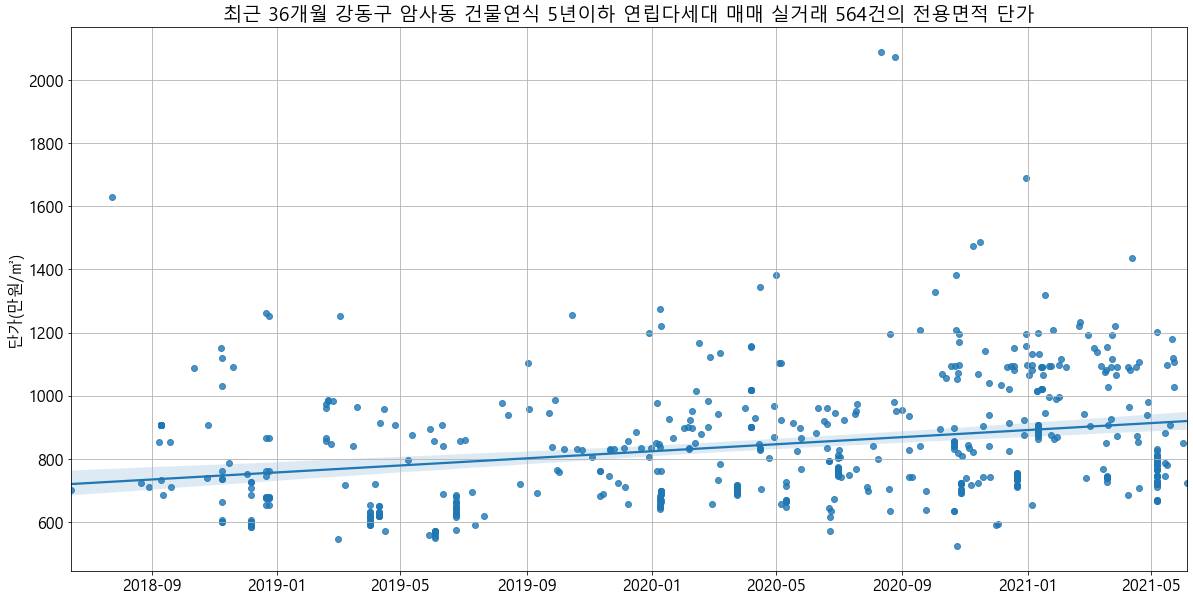

In [20]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_df['계약날짜']), y=target_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [21]:
target_last_df = target_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last').reset_index(drop=True)

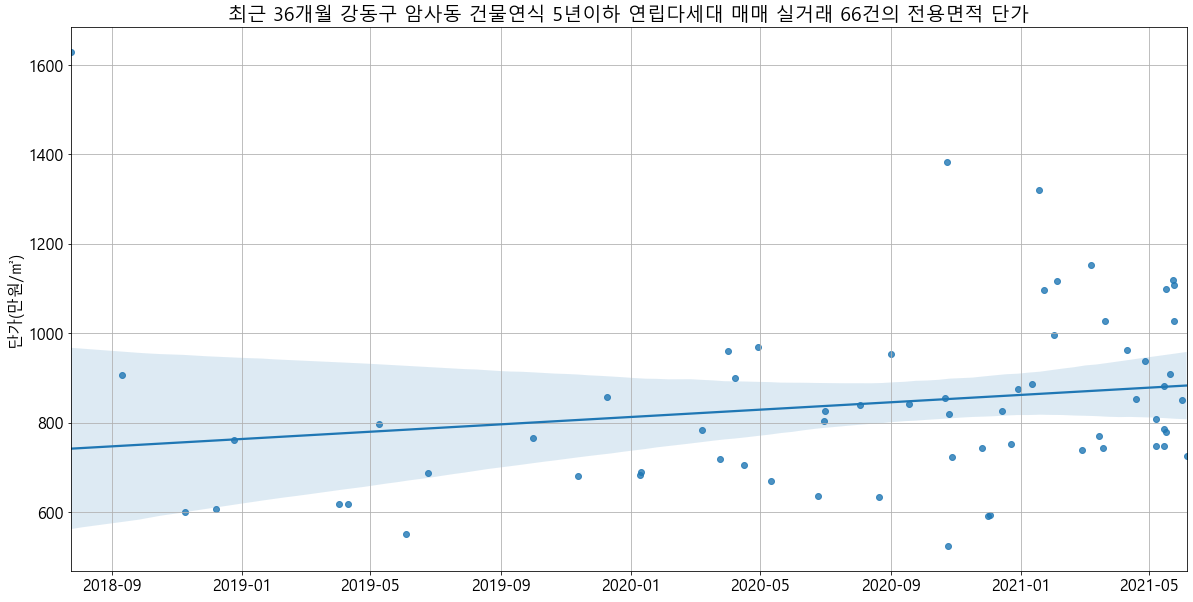

In [22]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('최근 {}개월 {} {} 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_period, target_gu, target_dong, target_building_age, target_house, target_last_df.shape[0]))
plt.grid(True)
ax.xaxis.update_units(target_last_df['계약날짜'])
sns.regplot(x=ax.xaxis.convert_units(target_last_df['계약날짜']), y=target_last_df['단가(만원/㎡)'])
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_산포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [23]:
target_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [24]:
target_df2 = house_merge_df[
    (house_merge_df['구'] == target_gu)
    &(house_merge_df['동'] == target_dong)
    #&(house_merge_df['계약날짜'] >= (date_today - pd.DateOffset(months=target_period)))
    &(house_merge_df['계약날짜기준_건물연식'] <= target_building_age)
    #&(house_merge_df['용도지역명1'].str.contains(target_purpose))
]
print(target_df2.shape)
target_df2.head()

(3210, 23)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동
11363,서울특별시 강동구 암사동 456-45,고덕로20다길 21-12,(456-45),54.60,30.52,11000,4,2001.0,5.0,2006-02-27,201.465201,20.0,연립다세대,대,131.1,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),강동구,암사동
11364,서울특별시 강동구 암사동 456-45,고덕로20다길 21-12,(456-45),65.46,36.59,13000,3,2001.0,5.0,2006-02-27,198.594562,20.0,연립다세대,대,131.1,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),강동구,암사동
11365,서울특별시 강동구 암사동 456-45,고덕로20다길 21-12,(456-45),65.46,36.59,13000,2,2001.0,5.0,2006-02-27,198.594562,20.0,연립다세대,대,131.1,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),강동구,암사동
11366,서울특별시 강동구 암사동 456-45,고덕로20다길 21-12,(456-45),48.99,27.39,6000,1,2001.0,5.0,2006-02-27,122.473974,20.0,연립다세대,대,131.1,제2종일반주거지역,지정되지않음,다세대,평지,가로장방,세로한면(가),강동구,암사동
11382,서울특별시 강동구 암사동 469-20,고덕로20마길 39,현진빌리지(469-20),29.49,20.00,22200,2,2012.0,0.0,2012-02-11,752.797558,9.0,연립다세대,대,425.3,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로한면(가),강동구,암사동


In [25]:
target_df2 = get_index_applied_prices(target_df2)

<AxesSubplot:title={'center':'강동구 암사동 계약날짜기준 건물연식 5년이하 연립다세대 매매 실거래 3210건의 전용면적 단가'}, xlabel='단가(만원/㎡)', ylabel='Count'>

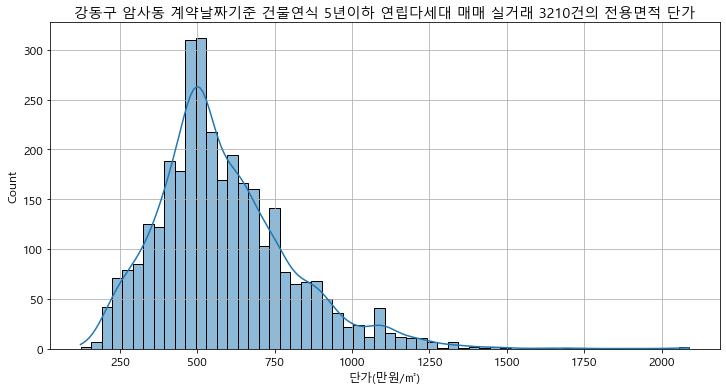

In [26]:
font = {'size': 12}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(12,6))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 {}건의 전용면적 단가'.format(target_gu, target_dong, target_building_age, target_house, target_df2.shape[0]))
plt.grid(True)
sns.histplot(target_df2['단가(만원/㎡)'], kde=True)

In [27]:
target_df3 = target_df2[['지번주소', '건물(단지)명', '건축년도', '층', '전용면적(㎡)', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
target_df3 = target_df3.sort_values(['지번주소', '건축년도', '계약날짜']).reset_index(drop=True)
target_df3.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)

In [28]:
concat_df = pd.concat([target_df2])

In [29]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '전용면적(㎡)', '계약날짜']).reset_index(drop=True)
concat_df = concat_df.drop_duplicates(['지번주소', '건축년도', '전용면적(㎡)'], keep='last').reset_index(drop=True)

In [30]:
concat_df['단가평균'] = concat_df[['지번주소', '건축년도', '단가(만원/㎡)']].groupby(['지번주소', '건축년도']).transform('mean')['단가(만원/㎡)']
concat_df['지수적용단가평균'] = concat_df[['지번주소', '건축년도', '지수적용단가']].groupby(['지번주소', '건축년도']).transform('mean')['지수적용단가']

In [31]:
concat_df = concat_df.sort_values(['지번주소', '건축년도', '평가날짜']).reset_index(drop=True)
print(concat_df.shape)
concat_df.head()

(1526, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
0,서울특별시 강동구 암사동 421-13,암사길 92,에코빌,53.98,35.68,22800,2,2009.0,5.0,2014-12-03,422.378659,12.0,연립다세대,대,367.0,제2종일반주거지역,지정되지않음,주상용,평지,사다리형,소로한면,강동구,암사동,619.473233,2021-03-01,381.51445,533.532062
1,서울특별시 강동구 암사동 421-13,암사길 92,에코빌,57.16,37.78,20200,2,2009.0,1.0,2010-07-17,353.393982,12.0,연립다세대,대,367.0,제2종일반주거지역,지정되지않음,주상용,평지,사다리형,소로한면,강동구,암사동,481.979788,2021-03-01,381.51445,533.532062
2,서울특별시 강동구 암사동 421-13,암사길 92,에코빌,61.94,40.94,27000,2,2009.0,0.0,2009-10-07,435.905715,12.0,연립다세대,대,367.0,제2종일반주거지역,지정되지않음,주상용,평지,사다리형,소로한면,강동구,암사동,571.903814,2021-03-01,381.51445,533.532062
3,서울특별시 강동구 암사동 421-13,암사길 92,에코빌,73.16,41.22,23000,5,2009.0,5.0,2014-02-03,314.379442,12.0,연립다세대,대,367.0,제2종일반주거지역,지정되지않음,주상용,평지,사다리형,소로한면,강동구,암사동,460.771411,2021-03-01,381.51445,533.532062
4,서울특별시 강동구 암사동 421-136,구천면로 365-8,세림힐하우스,34.45,22.87,25500,2,2016.0,1.0,2017-06-14,740.203193,5.0,연립다세대,대,1146.0,제2종일반주거지역,지정되지않음,주상용,평지,부정형,소로각지,강동구,암사동,938.848484,2021-03-01,730.31821,860.614429


In [32]:
concat_last_df = concat_df.drop_duplicates(subset=['지번주소', '건축년도'], keep='last')
print(concat_last_df.shape)
concat_last_df

(405, 27)


,지번주소,도로명,건물(단지)명,전용면적(㎡),대지권면적(㎡),거래금액(만원),층,건축년도,계약날짜기준_건물연식,계약날짜,단가(만원/㎡),건물연식,부동산유형,지목명,토지면적,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,구,동,지수적용단가,평가날짜,단가평균,지수적용단가평균
3,서울특별시 강동구 암사동 421-13,암사길 92,에코빌,73.160,41.22,23000,5,2009.0,5.0,2014-02-03,314.379442,12.0,연립다세대,대,367.0,제2종일반주거지역,지정되지않음,주상용,평지,사다리형,소로한면,강동구,암사동,460.771411,2021-03-01,381.514450,533.532062
16,서울특별시 강동구 암사동 421-136,구천면로 365-8,세림힐하우스,34.030,22.59,30000,6,2016.0,5.0,2021-05-15,881.575081,5.0,연립다세대,대,1146.0,제2종일반주거지역,지정되지않음,주상용,평지,부정형,소로각지,강동구,암사동,881.575081,2021-05-15,730.318210,860.614429
21,서울특별시 강동구 암사동 421-2,암사길 100,헤렌하우스,37.730,22.87,32200,2,2016.0,5.0,2021-04-19,853.432282,5.0,연립다세대,대,126.0,제2종일반주거지역,지정되지않음,주상기타,평지,사다리형,소로각지,강동구,암사동,853.432282,2021-04-19,831.058821,843.041633
23,서울특별시 강동구 암사동 421-29,암사18길 5,우주아트빌,75.030,34.17,15000,2,2001.0,5.0,2006-08-19,199.920032,20.0,연립다세대,대,264.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로각지,강동구,암사동,437.682755,2021-03-01,190.227999,438.050397
39,서울특별시 강동구 암사동 421-32,구천면로 365-22,엘림 하우스,53.560,30.69,28200,3,2017.0,0.0,2017-06-02,526.512323,4.0,연립다세대,대,145.0,제2종일반주거지역,지정되지않음,다세대,평지,부정형,소로한면,강동구,암사동,667.810272,2021-03-01,529.405223,671.479528
42,서울특별시 강동구 암사동 421-51,암사18길 24,엘림하우스,53.660,30.50,28600,3,2016.0,0.0,2016-10-13,532.985464,5.0,연립다세대,대,337.0,제2종일반주거지역,지정되지않음,다세대,평지,세로장방,세로각지(가),강동구,암사동,698.060056,2021-03-01,541.224267,708.850555
43,서울특별시 강동구 암사동 421-53,암사길 82,삼화빌,75.150,34.75,21000,4,2002.0,4.0,2006-11-18,279.441118,19.0,연립다세대,대,278.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,강동구,암사동,543.630384,2021-03-01,279.441118,543.630384
46,서울특별시 강동구 암사동 421-60,암사길 86-5,그랑밸리(421-60),64.200,37.00,29000,5,2009.0,4.0,2013-05-24,451.713396,12.0,연립다세대,대,221.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로한면(가),강동구,암사동,669.554180,2021-03-01,427.790575,629.691020
56,서울특별시 강동구 암사동 421-61,암사길 86-11,K-PARK,58.230,37.07,32000,4,2016.0,0.0,2016-08-18,549.544908,5.0,연립다세대,대,545.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,세로각지(가),강동구,암사동,728.183412,2021-03-01,699.243662,903.650984
58,서울특별시 강동구 암사동 421-71,암사길 86,우주맨션(421-71),44.110,21.15,15000,4,2002.0,5.0,2007-10-05,340.058944,19.0,연립다세대,대,162.0,제2종일반주거지역,지정되지않음,다세대,평지,사다리형,소로각지,강동구,암사동,530.329516,2021-03-01,324.924143,560.902545


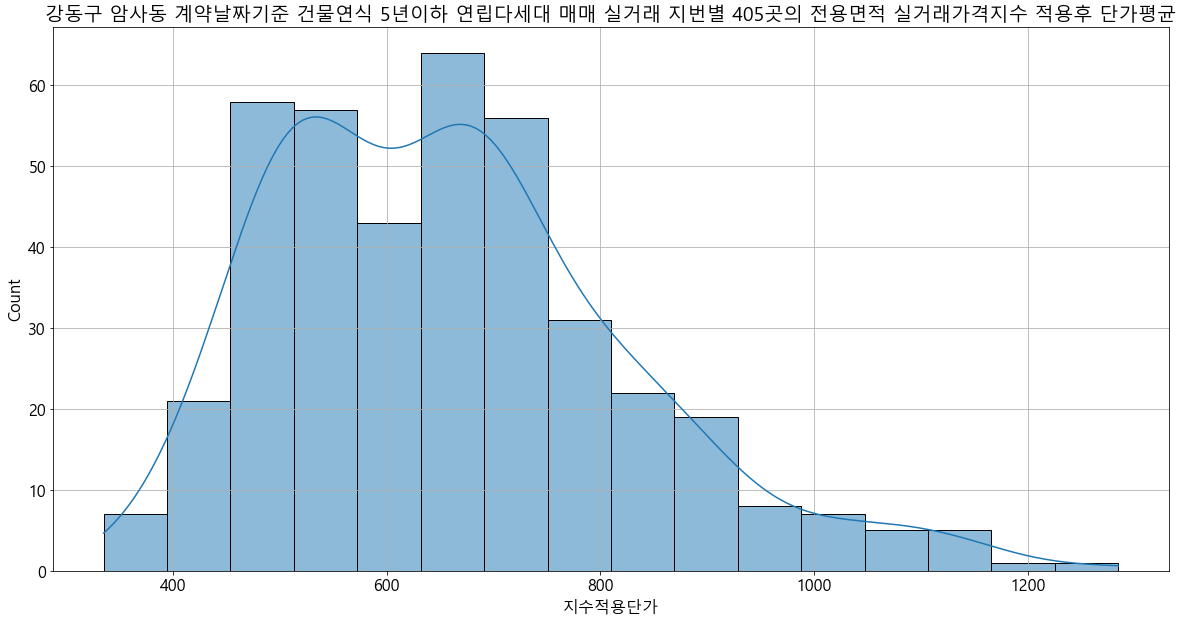

In [33]:
font = {'size': 16}
matplotlib.rc('font', **font)
f, ax = plt.subplots(figsize=(20,10))
plt.title('{} {} 계약날짜기준 건물연식 {}년이하 {} 매매 실거래 지번별 {}곳의 전용면적 실거래가격지수 적용후 단가평균'.format(target_gu, target_dong, target_building_age, target_house, concat_last_df.shape[0]))
plt.grid(True)
sns.histplot(concat_last_df['지수적용단가'], kde=True)
plt.savefig('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지번별_분포도.png'.format(target_gu, target_dong, target_house, date_today_record))

In [34]:
concat_last_df = concat_last_df.sort_values(['지번주소']).reset_index(drop=True)

In [35]:
concat_last_df = concat_last_df[['지번주소', '건물(단지)명', '건축년도', '전용면적(㎡)', '층', '계약날짜', '단가(만원/㎡)', '평가날짜', '지수적용단가', '용도지역명1', '부동산유형']]
concat_last_df.rename(columns={'계약날짜':'마지막_계약날짜'}, inplace=True)
concat_last_df.head()

,지번주소,건물(단지)명,건축년도,전용면적(㎡),층,마지막_계약날짜,단가(만원/㎡),평가날짜,지수적용단가,용도지역명1,부동산유형
0,서울특별시 강동구 암사동 421-13,에코빌,2009.0,73.16,5,2014-02-03,314.379442,2021-03-01,460.771411,제2종일반주거지역,연립다세대
1,서울특별시 강동구 암사동 421-136,세림힐하우스,2016.0,34.03,6,2021-05-15,881.575081,2021-05-15,881.575081,제2종일반주거지역,연립다세대
2,서울특별시 강동구 암사동 421-2,헤렌하우스,2016.0,37.73,2,2021-04-19,853.432282,2021-04-19,853.432282,제2종일반주거지역,연립다세대
3,서울특별시 강동구 암사동 421-29,우주아트빌,2001.0,75.03,2,2006-08-19,199.920032,2021-03-01,437.682755,제2종일반주거지역,연립다세대
4,서울특별시 강동구 암사동 421-32,엘림 하우스,2017.0,53.56,3,2017-06-02,526.512323,2021-03-01,667.810272,제2종일반주거지역,연립다세대


In [36]:
concat_last_df.to_excel('./국토교통부_실거래가_공개시스템/집값분석/{}_{}_{}_{}/지수적용_마지막_실거래가.xlsx'.format(target_gu, target_dong, target_house, date_today_record), index=False)